# Squeezing in atomic qudits

In this notebook we will see how it is possible to detect entanglement in cold atomic experiments through the squeezing of the measured histograms. The notebook is structured as follows:

1. We start with a simple motivational example of two qubits, where we see that entanglement can reduce fluctuations in certain cases.
2. Next, we discuss an experimental implementation, where 500 atoms were condensed into a Bose-Einstein condensate and squeezing was observed.
3. We will then study how you can simulate the experiments on your own laptop through `qiskt-cold-atom`.
4. In the last section, we show how to send such calculations to a cloud simulator.

## Two correlated coins - a toy example for squeezing 

To understand the motivation for studying squeezing, we start out with a two-qubit quantum circuit. In a first step, we put both qubits into a 50-50 superposition as shown below.

In [1]:
import numpy as np

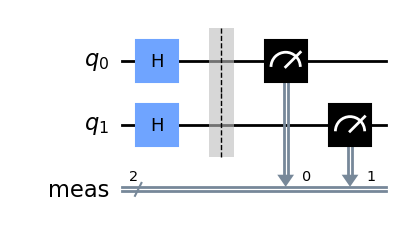

In [2]:
from qiskit import QuantumCircuit

circuit = QuantumCircuit(2)

# initialization to create a 50 - 50 superposition
circuit.h(0)
circuit.h(1)

# measurement
circuit.measure_all()
circuit.draw("mpl", style='clifford')

Each execution of such a circuit corresponds to flipping two coins. By writing down the outcomes of many executions we obtain a histogram of the counts where 0 and 1 could be interpreted as heads and tails, respectively (or vice versa).

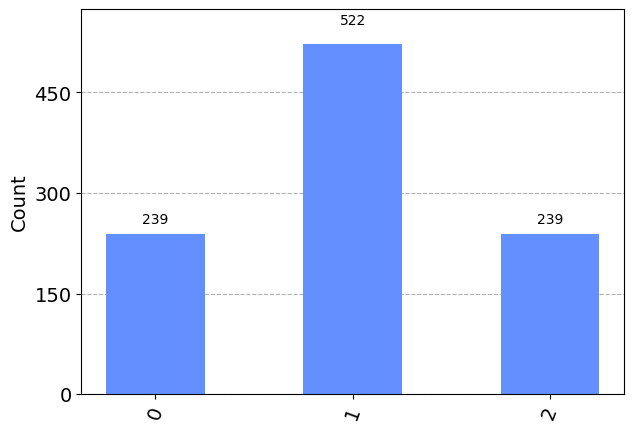

In [3]:
from qiskit import Aer
from qiskit.visualization import plot_histogram

def bit_counts_to_Lz(counts):
    """transform bitstring counts to collective counts.

    Args:
        counts: a dict whose keys are the observed integers for the spin
                and whose values is the number of observations

    Returns:
        counts: a dict whose keys are the observed integers for the total observed numbers of up
                and whose values is the number of observations
    """
    lz_counts = {}
    for bitstring, count in counts.items():
        measured_label = bitstring.count("1")
        if str(measured_label) in lz_counts:
            lz_counts[str(measured_label)] += count
        else:
            lz_counts[str(measured_label)] = count

    return lz_counts


qasm_simulator = Aer.get_backend("aer_simulator")
job = qasm_simulator.run(circuit, shots=1000)
counts = job.result().get_counts()
lz_counts_uncorrelated = bit_counts_to_Lz(counts)
plot_histogram(lz_counts_uncorrelated)

The histogram above shows the probability of obtaining the collective counts, i.e. the number of 1's in each measured bit-string. For example, since each state 00, 01, 10, and 11 has a 25\% probability of occuring we have a 50\% probability of measuring 1 (i.e. states 01 and 10) and a 25% probability of measuring 2 (i.e. state 11). In the next step we will start correlating, i.e. entangling the qubits, and see how this correlation is visible in the histogram. 

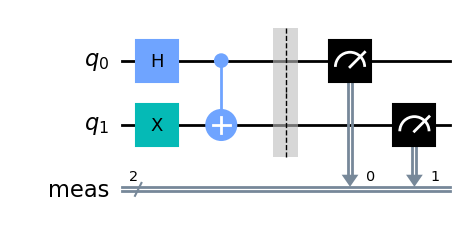

In [4]:
circuit = QuantumCircuit(2)

# initialization on x
circuit.h(0)
circuit.x(1)
circuit.cx(0, 1)

# measurement
circuit.measure_all()
circuit.draw("mpl", style='clifford')

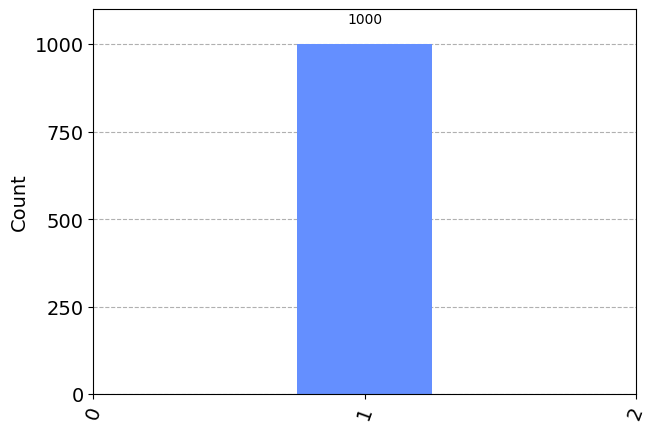

In [5]:
job = qasm_simulator.run(circuit, shots=1000)
counts = job.result().get_counts()
counts["00"] = 0
counts["11"] = 0
squeezed_lz_counts = bit_counts_to_Lz(counts)
plot_histogram(squeezed_lz_counts)

As we can see quite nicely the correlations between the qubits are inducing a reduction in the width of the observed histogram. It is this reduction that is called **squeezing** and its relation to quantum entanglement has motivated a large body of literature [1] and experimental work on this topic, which we will slightly touch on in the following example .

## Experimental implementation with 500 cold atoms

We now discuss some results from a [paper](https://arxiv.org/abs/1507.03782) on squeezing with cold atoms by Strobel et al. [2]. In this paper, $N_{at} = 500$ atoms were cooled down to form a Bose-Einstein condensate. In this state, they are indistinguishable and each of the atoms can be controlled to be in one of two internal states. Altogether the system can be described in terms of angular momentum operators $\hat{L}_i$ of length $\ell = \frac{N_{at}}{2}$. This system evolves under the Hamiltonian:

$$ H_{\text{OAT}}(\chi, \Delta, \Omega) =  \chi L_{z}^2 + \Delta L_{z} + \Omega L_{x}$$

- The first term arises from the interactions between the atoms. It is called *one-axis-twisting Hamiltonian*.
- The second term stems from an externally applied magnetic field and microwave. It introduces rotations around the z axis of the collective Bloch sphere. It's strength $\Delta$ is hence quite easily switched through the frequency of the externally applied magnetic field.
- The third term describes the Rabi coupling and its strength $\Omega$ is directly controlled through the amplitude of the applied microwave signal.


To observe squeezing the following actions were performed in the experiment. 

0. __Preparation__: We prepare the collective spin such that the Bloch-sphere-vector points to one of the poles. 

1. __First step__: The vector is rotated onto the equator by applying a very fast Rabi pulse such that only the third term of the Hamiltonian is of practical relevance. We can hence describe it by an $\mathcal{R}_y$ rotation.

2. __Second step__: The state is squeezed such that it starts to wrap around the Bloch-sphere. This happens under the evolution of the above Hamiltonian with suitably chosen parameters. A $\pi$-pulse in the middle is suppressing certain unwanted noise to improve the observed squeezing. The evolution can hence be described by the unitary:

$$\hat{U}_{oat} = e^{i\hat{H}_{oat}t}$$

3. __Third step__: In the last step we rotate the state around the $X$-axis. This rotation corresponds to the angle $\alpha$ in this notebook.

We can summarize this experiments with `qiskit-cold-atom` as follows:

In [6]:
from qiskit_cold_atom.providers import ColdAtomProvider
from qiskit_cold_atom.spins.spins_gate_library import OATGate
from qiskit.circuit import Parameter

import numpy as np

provider = ColdAtomProvider()
backend = provider.get_backend("collective_spin_simulator")

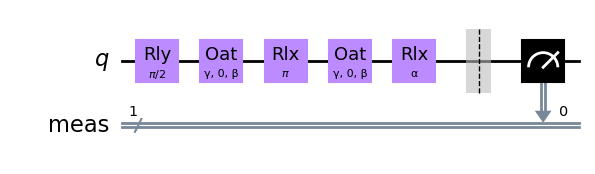

In [7]:
qc = QuantumCircuit(1)

alpha = Parameter("α")
beta = Parameter("β")
gamma = Parameter("γ")

qc.rly(np.pi / 2, 0)
qc.append(OATGate(chi=gamma, delta=0, omega=beta), qargs=[0])
qc.rlx(np.pi, 0)
qc.append(OATGate(chi=gamma, delta=0, omega=beta), qargs=[0])
qc.rlx(alpha, 0)
qc.measure_all()

qc.draw("mpl", style='clifford')

This circuit is run multiple times and the collective spin is observed for two evolution times. Let us simulate such an experiment for two extreme cases of angles with large and small squeezing. The parameters are chosen from the experimental paper.

In [8]:
# Number of atoms
Nat = 100

# The length of the spin
l = Nat / 2

# Strength of the rotation around x 
omegax = 2 * np.pi * 20

# Time of the evolution
time = 15e-3

# Strength of the Lz-squared operator
Lambda = 1.5
chi = Lambda * abs(omegax) / Nat;

In [9]:
alphas = np.array([50, 140]) / 180 * np.pi

circuit = qc.assign_parameters(
    {
        alpha: np.pi - alphas[0],
        beta: omegax * time / 2,
        gamma: chi * time / 2,
    },
    inplace=False,
)

job = backend.run(circuit, shots=1000, spin=Nat / 2)
counts1 = job.result().get_counts()


circuit = qc.assign_parameters(
    {
        alpha: np.pi - alphas[1],
        beta: omegax * time / 2,
        gamma: chi * time / 2,
    },
    inplace=False,
)

job = backend.run(circuit, shots=1000, spin=Nat / 2)
counts2 = job.result().get_counts()

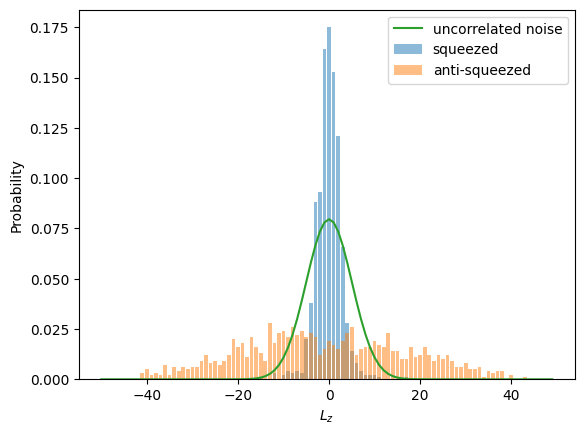

In [10]:
import matplotlib.pyplot as plt
from scipy.special import binom

f, ax = plt.subplots()

obs_num = np.array([int(key) for key in counts1.keys()])
obs_vals = np.array([val for val in counts1.values()])

ax.bar(
    obs_num - Nat / 2,
    obs_vals / obs_vals.sum(),
    align="center",
    alpha=0.5,
    label="squeezed",
)

obs_num = np.array([int(key) for key in counts2.keys()])
obs_vals = np.array([val for val in counts2.values()])

ax.bar(
    obs_num - Nat / 2,
    obs_vals / obs_vals.sum(),
    align="center",
    alpha=0.5,
    label="anti-squeezed",
)

# and compare to the binomial distribution;
ks = np.arange(Nat)
pk = binom(Nat, ks) * 0.5 ** ks * 0.5 ** (Nat - ks)
ax.plot(ks - Nat / 2, pk, label="uncorrelated noise", c="C2")
ax.legend()
ax.set_ylabel("Probability")
ax.set_xlabel(r"$L_z$");

The observed variance $\Delta^2$ is then compared to the variance of uncorrelated coin tosses, i.e. of a binomial distribution with $50%$ success probability, $\Delta^2_{SN} = \frac{N_{at}}{4}$. The observed squeezing $\Delta$ is then quantified in *dB* through the squeezing parameter:
$$\xi = 10 \log\left(\frac{\Delta^2}{\Delta^2_{SN}}\right)$$
In the histogram above we can see a squeezed state with a reduced variance. At this stage, we have discussed all the necessary ingredients to understand the experimental observations of the paper by Strobel. We will therefore simulate the observations at the reported evolution times ($t_1 = 15$ms, $t_1 = 25$ms) and compare the observed squeezing parameters to our simulations.

In [11]:
t1 = 15e-3
t2 = 25e-3

In [12]:
def mean_var_from_counts(counts):
    """calculate mean and variance from the counts.

    Args:
        counts: a dict whose keys are the observed integers for the spin
                and whose values is the number of observations

    Returns:
        mean, var: mean and variance of the observed counts
    """
    mean, var, count_sum = 0, 0, 0

    for k, v in counts.items():
        mean += int(k) * v
        count_sum += v

    mean = mean / count_sum
    for k, v in counts.items():
        var += (int(k) - mean) ** 2 * v / count_sum
    return mean, var

We now run the circuits for all the experimental data.

In [13]:
alphas = np.linspace(0, np.pi, 15)
variances_1 = np.zeros(len(alphas))
variances_2 = np.zeros(len(alphas))

for ii in range(len(alphas)):

    # first time step
    circuit = qc.assign_parameters(
        {
            alpha: alphas[ii],
            beta: omegax * t1 / 2,
            gamma: chi * t1 / 2,
        },
        inplace=False,
    )

    job = backend.run(circuit, shots=1000, spin=Nat / 2, seed=14)
    counts = job.result().get_counts()
    mean, var = mean_var_from_counts(counts)
    variances_1[ii] = var

    # and the second time step
    circuit = qc.assign_parameters(
        {
            alpha: alphas[ii],
            beta: omegax * t2 / 2,
            gamma: chi * t2 / 2,
        },
        inplace=False,
    )

    job = backend.run(circuit, shots=1000, spin=Nat / 2, seed=14)
    counts = job.result().get_counts()
    mean, var = mean_var_from_counts(counts)
    variances_2[ii] = var;

Import the data from the paper for comparison

In [14]:
# Import the data from the paper by Strobel et al.
strobel_15_dB = np.array(
    [
        0.51993068,
        10.39861352,
        20.5372617,
        30.41594454,
        40.81455806,
        45.49393414,
        50.6932409,
        56.152513,
        60.05199307,
        69.93067591,
        79.80935875,
        90.98786828,
        100.08665511,
        109.96533795,
        120.36395147,
        130.24263432,
        139.86135182,
        150.51993068,
        160.13864818,
        170.01733102,
        180.1559792,
    ]
)

strobel_15_alpha = np.array(
    [
        9.27455357,
        8.03571429,
        6.19419643,
        3.54910714,
        -0.46875,
        -2.27678571,
        -4.11830357,
        -4.01785714,
        -2.94642857,
        1.30580357,
        4.55357143,
        6.99776786,
        8.50446429,
        9.140625,
        10.41294643,
        10.546875,
        10.64732143,
        10.27901786,
        9.74330357,
        9.40848214,
        8.27008929,
    ]
)

# and the values for 25ms
strobel_25_dB = np.array(
    [
        0.51993068,
        10.39861352,
        20.5372617,
        30.41594454,
        40.81455806,
        45.49393414,
        50.6932409,
        56.152513,
        60.05199307,
        69.93067591,
        79.80935875,
        90.98786828,
        100.08665511,
        109.96533795,
        120.36395147,
        130.24263432,
        139.86135182,
        150.51993068,
        160.13864818,
        170.01733102,
        180.1559792,
    ]
)

strobel_25_alpha = np.array(
    [
        16.07142857,
        15.46875,
        14.02901786,
        11.71875,
        8.40401786,
        4.72098214,
        2.20982143,
        -0.46875,
        0.0,
        2.74553571,
        7.734375,
        10.98214286,
        13.39285714,
        14.89955357,
        15.73660714,
        16.50669643,
        17.00892857,
        17.31026786,
        17.24330357,
        16.77455357,
        15.80357143,
    ]
)

and calculate the variance as presented above.

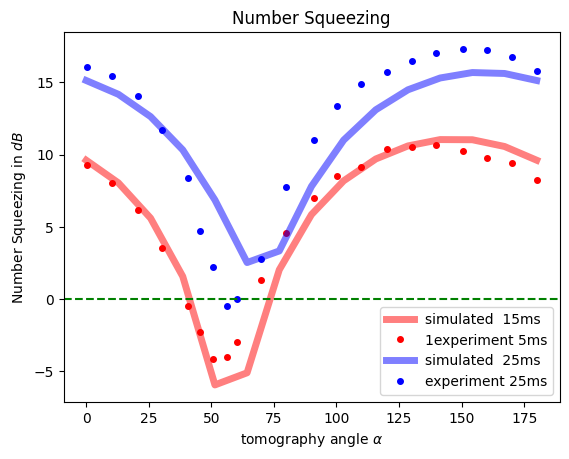

In [15]:
def number_squeezing_factor_to_db(var_CSS, var):
    """Calcululate the squeezing parameter from the observed variance."""
    return 10 * np.log10(var / var_CSS)

f, ax = plt.subplots()
ax.set_title("Number Squeezing")

ax.plot(
    np.rad2deg(np.pi - alphas),
    number_squeezing_factor_to_db(l / 2, variances_1),
    "r-",
    lw=5,
    label="simulated  15ms",
    alpha=0.5,
)
ax.plot(strobel_15_dB, strobel_15_alpha, "ro", label="1experiment 5ms", markersize=4)
ax.plot(
    np.rad2deg(np.pi - alphas),
    number_squeezing_factor_to_db(l / 2, variances_2),
    "b-",
    lw=5,
    label="simulated  25ms",
    alpha=0.5,
)
ax.plot(strobel_25_dB, strobel_25_alpha, "bo", label="experiment 25ms", markersize=4)
ax.axhline(y=0, color="g", linestyle="--")
ax.set_ylabel(r"Number Squeezing in $dB$")
ax.set_xlabel(r"tomography angle $\alpha$")
ax.legend();

As we can see the experiments are well understood as a quantum information circuit with specifically chosen parmeters.

## Optional: Working on a cloud simulator

We would also like to send such circuits to some real hardware and investigate these results. In this last section, we will present this possibility with the [alqor](https://qlued.alqor.io) provider. 


<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this part of the tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and token for this provider. You can obtain such credentials by visiting the <a href ='https://qlued.alqor.io/accounts/login/'>sign-up page</a></div>

In a first step, it is necessary to import the cold atom provider.

In [16]:
from qiskit_cold_atom.providers import ColdAtomProvider
from pprint import pprint

Saving/enabling your backend credentials (Optional if not alreayd done).

In [17]:
# save an account to disk
#provider = ColdAtomProvider.save_account(
#    url=[
#        "https://qlued.alqor.io/api/v2/singlequdit",
#        "https://qlued.alqor.io/api/v2/multiqudit",
#        "https://qlued.alqor.io/api/v2/fermions",
#    ],
#    username="name",
#    token="token",
#    overwrite=True
#)

In [ ]:
# or enable an account in the current session
#provider = ColdAtomProvider.enable_account(
#    url=[
#        "https://qlued.alqor.io/api/v2/singlequdit",
#        "https://qlued.alqor.io/api/v2/multiqudit",
#        "https://qlued.alqor.io/api/v2/fermions",
#    ],
#    username="name",
#    token="token",
#    overwrite=True
#)

We can now load the necessary backend

In [18]:
provider = ColdAtomProvider.load_account()

spin_device_backend = provider.get_backend("alqor_singlequdit_simulator")
pprint(spin_device_backend.configuration().supported_instructions)

['rlx', 'rlz', 'rlz2', 'barrier', 'measure', 'load']


As you can see from above the simulator backend does not provide the OAT gate that we used previously. However, we will simply trotterize it in the simulation.

In [19]:
Nat = 200
l = Nat / 2  # spin length
omegax = 2 * np.pi * 20
t1 = 15e-3
t2 = 25e-3
Lambda = 1.5

chi = Lambda * abs(omegax) / Nat

Ntrott = 15
alphas = np.linspace(0, np.pi, 15)

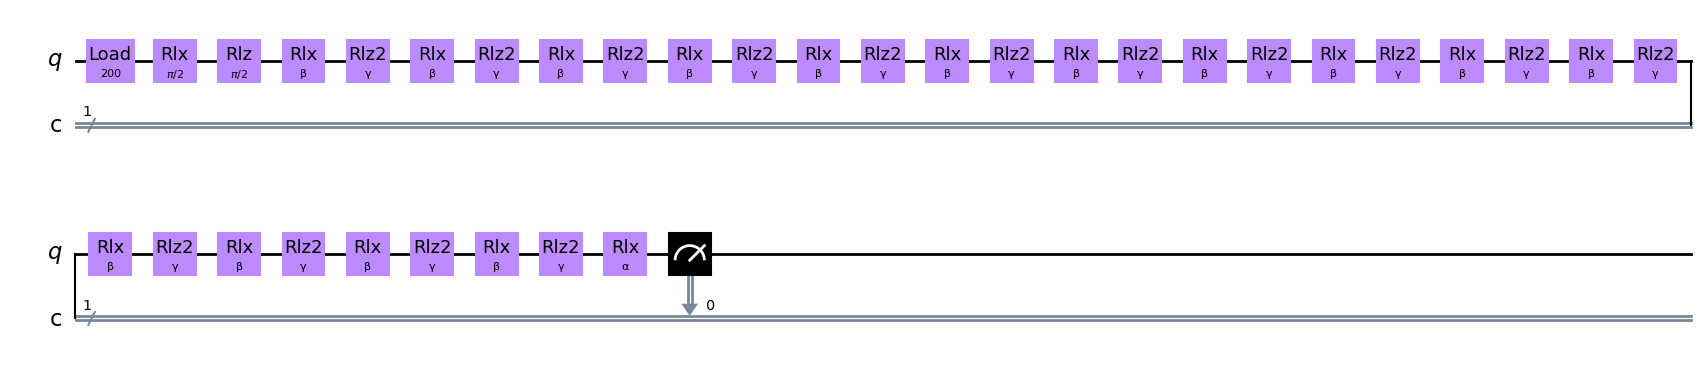

In [20]:
alpha = Parameter("α")
beta = Parameter("β")
gamma = Parameter("γ")

qc_trott = QuantumCircuit(1, 1)
qc_trott.load_spins(Nat, 0)
qc_trott.rlx(np.pi / 2, 0)
qc_trott.rlz(np.pi / 2, 0)
for ii in range(Ntrott):
    qc_trott.rlx(beta, 0)
    qc_trott.rlz2(gamma, 0)
qc_trott.rlx(alpha, 0)
qc_trott.measure(0, 0)
qc_trott.draw(output="mpl")

as before we are now ready to send the job to the back-end and run it.

In [21]:
circuit1_list = [
    qc_trott.assign_parameters(
        {alpha: -a % (2 * np.pi), gamma: chi * t1 / Ntrott, beta: omegax * t1 / Ntrott},
        inplace=False,
    )
    for a in alphas
]
job1 = spin_device_backend.run(circuit1_list, shots=500)

we can now verify that it was successfully run through its job id. This comes in especially hand for longer jobs.

In [22]:
job1.job_id()

'20230407_084217-singlequdit-fred-613a5'

In [23]:
job_retrieved1 = spin_device_backend.retrieve_job(job_id=job1.job_id())

print("job status: ", job_retrieved1.status())

job status:  JobStatus.DONE


Once the job status has switch towards done, the counts can be retrieved and analyzed. In the meantime we can send out the job for the other time:

In [24]:
circuit2_list = [
    qc_trott.assign_parameters(
        {alpha: -a % (2 * np.pi), gamma: chi * t2 / Ntrott, beta: omegax * t2 / Ntrott},
        inplace=False,
    )
    for a in alphas
]

In [25]:
job2 = spin_device_backend.run(circuit2_list, shots=500)

In [26]:
job2.job_id()

'20230407_084317-singlequdit-fred-c8f9c'

In [27]:
job_retrieved2 = spin_device_backend.retrieve_job(job_id=job2.job_id())

print("job status: ", job_retrieved2.status())

job status:  JobStatus.INITIALIZING


The result of the job can be accessed by directly calling `job.result()` which returns a `Qiskit.Result` object and be transformed into the necessary variances.

In [28]:
result1 = job_retrieved1.result()
result2 = job_retrieved2.result()

outcomes1 = [result1.get_memory(i) for i in range(len(circuit1_list))]
outcomes2 = [result2.get_memory(i) for i in range(len(circuit2_list))]

variances_1 = [np.var(np.array(counts1, dtype=float)) for counts1 in outcomes1]
variances_2 = [np.var(np.array(counts2, dtype=float)) for counts2 in outcomes2]

variances_1 = np.array(variances_1)
variances_2 = np.array(variances_2)

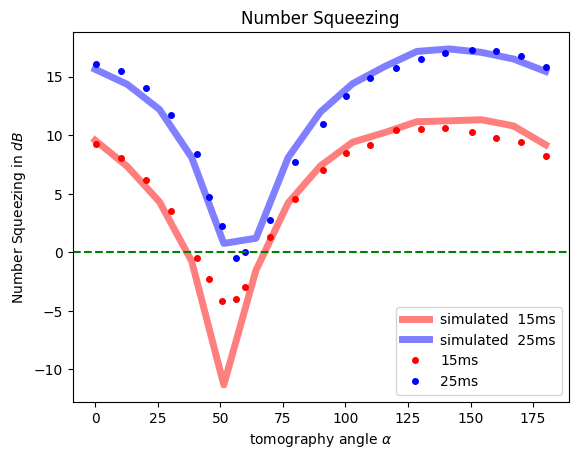

In [29]:
f, ax = plt.subplots()
ax.set_title("Number Squeezing")
plt.plot(
    np.rad2deg(alphas),
    number_squeezing_factor_to_db(l / 2, variances_1),
    "r-",
    lw=5,
    label="simulated  15ms",
    alpha=0.5,
)
plt.plot(
    np.rad2deg(alphas),
    number_squeezing_factor_to_db(l / 2, variances_2),
    "b-",
    lw=5,
    label="simulated  25ms",
    alpha=0.5,
)

plt.plot(strobel_15_dB, strobel_15_alpha, "ro", label="15ms", markersize=4)
plt.plot(strobel_25_dB, strobel_25_alpha, "bo", label="25ms", markersize=4)


ax.axhline(y=0, color="g", linestyle="--")
ax.set_ylabel(r"Number Squeezing in $dB$")
ax.set_xlabel(r"tomography angle $\alpha$")
ax.legend()

## References
[1] [Luca Pezze et al.](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.90.035005) *Quantum metrology with nonclassical states of atomic ensembles*. Reviews of Modern Physics 90, 035005 (2018). 

[2] [Helmut Strobel et al.](https://doi.org/10.1126/science.1250147) *Fisher information and entanglement of non-Gaussian spin states*. Science 345, 424 (2014). 


In [16]:
import qiskit.tools.jupyter

%qiskit_version_table